## [*See a £100/tonne carbon dividend in PolicyEngine*](https://policyengine.org/uk/population-impact?adult_bi=15_55&carbon_tax=100&child_bi=15_55&senior_bi=15_55)

Earlier this month, the International Panel on Climate Change ([IPCC](https://www.ipcc.ch/)) released the [third installment](https://report.ipcc.ch/ar6wg3/) of its Sixth Assessment Report, titled "Mitigation of Climate Change."
The report covered a wide range of policy options to reduce carbon emissions, as well as a wide range of benefits such policies would have for humanity.

As [Dana Nuccitelli of Citizens' Climate Lobby noted](https://citizensclimatelobby.org/blog/policy/the-latest-ipcc-report-has-a-lot-to-say-about-carbon-fee-and-dividend/), the report has a lot to say about one policy in particular: it contains 680 mentions of carbon pricing, from the economic theory and evidence to policy design and political support.
While most climate change proposals require funding, carbon pricing policies raise revenue by charging fossil fuel companies for their carbon pollution.
That means it also raises costs in isolation; to address this, the IPCC says, "Carbon pricing is most effective if revenues are redistributed or used impartially."
What's more impartial than redistributing to everyone equally?

For Earth Day weekend, we're following up [our report on US carbon dividends](https://www.ubicenter.org/us-carbon-dividend) with an analysis of the policy in the UK.
Using [PolicyEngine](http://policyengine.org), we find that levying a fee on each tonne of carbon emissions, and redistributing the proceeds equally to all UK residents, would have a progressive distributional impact.
A carbon dividend would significantly reduce poverty and inequality, and the larger the program, the more of each it does.

## Methodology

As we've written on the [PolicyEngine blog today](https://blog.policyengine.org/how-policyengine-estimates-the-effects-of-uk-carbon-taxes-260ccfc5d97c), PolicyEngine uses a range of data sources and techniques to estimate how carbon taxes would affect different types of households.
PolicyEngine is a *static* app, so it assumes that behaviour, including carbon emissions, do not respond to policy changes.

In this analysis, we use PolicyEngine to first explore a single policy of a £100 per tonne carbon dividend.
From there, we show that the poverty impacts of carbon dividends increase roughly in proportion to the size of the carbon tax.
In each case, we assume that consumers bear 100% of the incidence of the carbon tax; changing this assumption doesn't significantly change the policy's income-based distributional impact.

## [£100/tonne carbon dividend](https://policyengine.org/uk/population-impact?adult_bi=15_55&carbon_tax=100&child_bi=15_55&senior_bi=15_55)



https://policyengine.org/uk/population-impact?adult_bi=15_55&carbon_tax=100&child_bi=15_55&senior_bi=15_55

## Varying the price

Since PolicyEngine is static, the revenue--and therefore the dividend--increases linearly with the carbon price.
Each £10 per tonne funds a weekly dividend of £1.56 per person.

In [1]:
# Generate data; this takes about 3 minutes.

from policyengine.countries import UK
import pandas as pd

uk = UK()

tax_rates = list(range(0, 105, 5))
changes = dict(
    carbon_tax=[],
    ubi=[],
    poverty=[],
    deep_poverty=[],
    child_poverty=[],
    deep_child_poverty=[],
    adult_poverty=[],
    deep_adult_poverty=[],
)

baseline_in_poverty = uk.baseline.calc("in_poverty_bhc", map_to="person")
baseline_in_deep_poverty = uk.baseline.calc(
    "in_deep_poverty_bhc", map_to="person"
)
is_child = uk.baseline.calc("is_child", map_to="person")
is_adult = uk.baseline.calc("is_adult", map_to="person")


def pct_change(x, y):
    return x / y - 1


def pct_change_mean(x, y):
    return pct_change(x.mean(), y.mean())


for tax_rate in tax_rates:
    print(tax_rate)
    baseline, reformed = uk._get_microsimulations(dict(carbon_tax=tax_rate))
    revenue = reformed.calc("carbon_tax").sum()
    weekly_ubi = revenue / baseline.calc("people").sum() / 52
    baseline, reformed = uk._get_microsimulations(
        dict(
            carbon_tax=tax_rate,
            child_bi=weekly_ubi,
            adult_bi=weekly_ubi,
            senior_bi=weekly_ubi,
        )
    )
    changes["carbon_tax"] += [tax_rate]
    changes["ubi"] += [weekly_ubi]
    in_poverty = reformed.calc("in_poverty_bhc", map_to="person")
    in_deep_poverty = reformed.calc("in_deep_poverty_bhc", map_to="person")
    changes["poverty"] += [pct_change_mean(in_poverty, baseline_in_poverty)]
    changes["deep_poverty"] += [
        pct_change_mean(in_deep_poverty, baseline_in_deep_poverty)
    ]
    changes["child_poverty"] += [
        pct_change_mean(in_poverty[is_child], baseline_in_poverty[is_child])
    ]
    changes["deep_child_poverty"] += [
        pct_change_mean(
            in_deep_poverty[is_child], baseline_in_deep_poverty[is_child]
        )
    ]
    changes["adult_poverty"] += [
        pct_change_mean(in_poverty[is_adult], baseline_in_poverty[is_adult])
    ]
    changes["deep_adult_poverty"] += [
        pct_change_mean(
            in_deep_poverty[is_adult], baseline_in_deep_poverty[is_adult]
        )
    ]


df = pd.DataFrame(changes)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


In [60]:
import plotly.express as px
from ubicenter import format_fig
from ubicenter.plotly import LIGHT_BLUE, DARK_BLUE

LABELS = dict(
    poverty="Poverty",
    deep_poverty="Deep poverty",
    child_poverty="Child poverty",
    deep_child_poverty="Deep child poverty",
    adult_poverty="Adult poverty",
    deep_adult_poverty="Deep adult poverty",
    carbon_tax="Price per tonne of carbon emissions",
    poverty_impact="Poverty impact",
    ubi="Weekly dividend",
)

HOVER_TEMPLATE = "%{customdata[0]}<extra></extra>"

# UBI by tax rate
df["hover"] = (
    "A carbon tax of £"
    + df.carbon_tax.astype(str)
    + " per tonne would fund a weekly dividend of £"
    + df.ubi.round(2).astype(str)
)

fig = px.line(
    df,
    x="carbon_tax",
    y="ubi",
    custom_data=["hover"],
    title="Weekly carbon dividend by per-tonne carbon price",
    color_discrete_sequence=[LIGHT_BLUE],
    labels=LABELS,
)
fig.update_layout(
    yaxis_tickprefix="£",
    xaxis_tickprefix="£",
).update_traces(hovertemplate=HOVER_TEMPLATE)
format_fig(fig)


As the carbon dividend increases in price, the poverty and deep poverty impacts increase roughly linearly, with some slight diminishing returns starting around £90 per tonne.

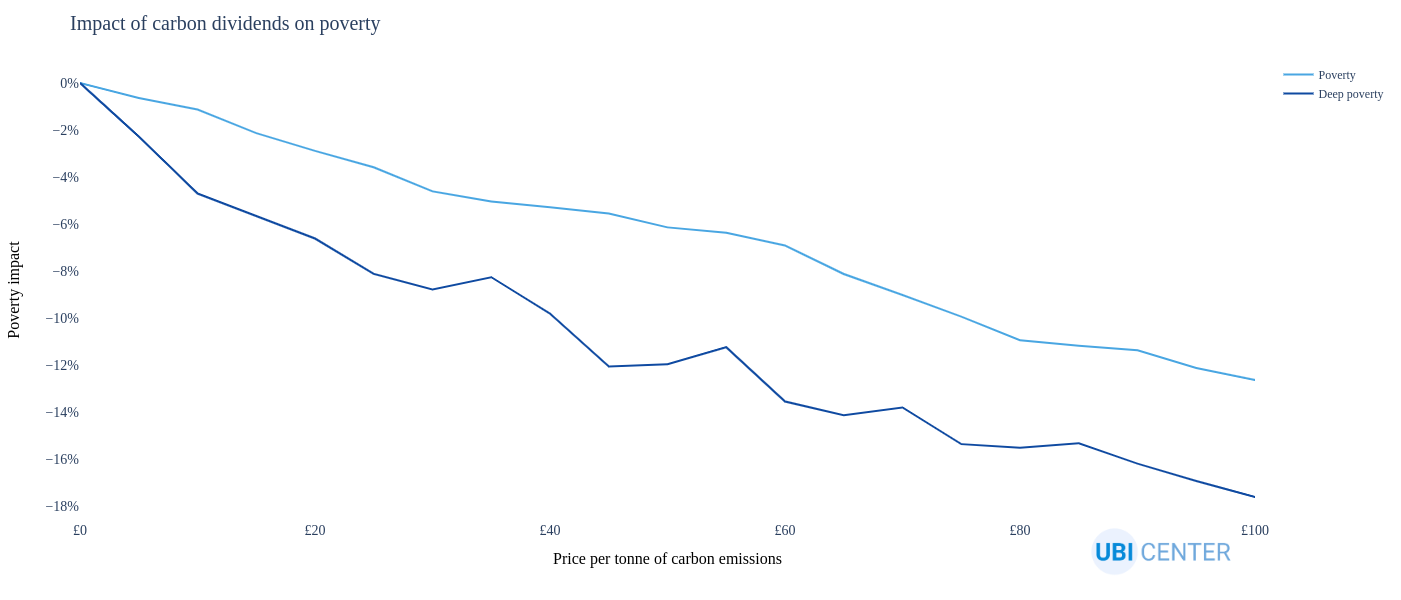

In [61]:
pov_deep_pov = df.melt("carbon_tax", ["poverty", "deep_poverty"], value_name="poverty_impact")
pov_deep_pov.variable = pov_deep_pov.variable.map(LABELS)
pov_deep_pov["hover"] = (
    "A £"
    + pov_deep_pov.carbon_tax.astype(str)
    + " carbon dividend would cut "
    + pov_deep_pov.variable.str.lower()
    + " by "
    + (-100 * pov_deep_pov.poverty_impact).round(1).astype(str)
    + "%"
)

fig = (
    px.line(
        pov_deep_pov,
        x="carbon_tax",
        y="poverty_impact",
        color="variable",
        color_discrete_sequence=[LIGHT_BLUE, DARK_BLUE],
        labels=LABELS,
        custom_data=["hover"],
    )
    .update_layout(
        title="Impact of carbon dividends on poverty",
        yaxis_tickformat=".0%",
        xaxis_tickprefix="£",
        legend_title="",
    )
    .update_traces(hovertemplate=HOVER_TEMPLATE)
)
format_fig(fig)


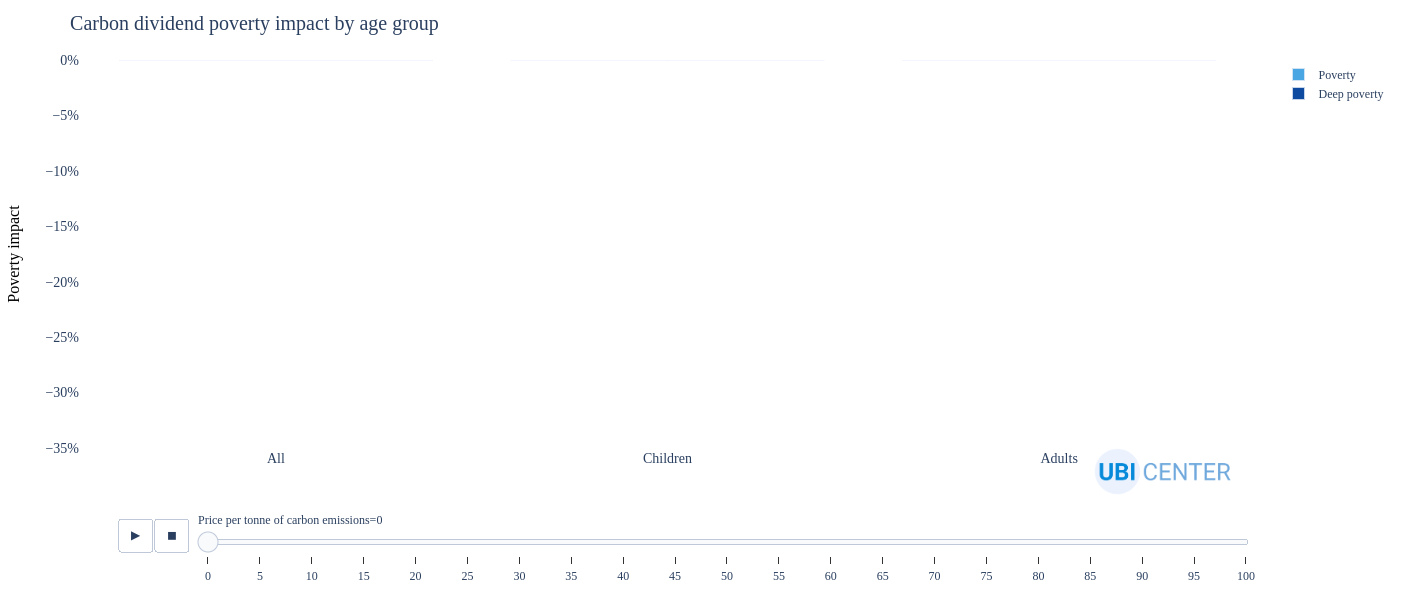

In [62]:
# Current the dataframe has columns [price, ubi, poverty, deep poverty, child poverty, deep child poverty, working-age poverty, deep working-age poverty, senior poverty, deep senior poverty]
# We need it with columns [price, age group, poverty type, value]

import numpy as np

long_df = df.melt(
    id_vars="carbon_tax",
    value_vars=[
        "poverty",
        "deep_poverty",
        "child_poverty",
        "deep_child_poverty",
        "adult_poverty",
        "deep_adult_poverty",
    ],
)
long_df["age_group"] = np.where(
    long_df.variable.str.contains("child"),
    "Children",
    np.where(long_df.variable.str.contains("adult"), "Adults", "All"),
)
long_df["poverty_type"] = np.where(
    long_df.variable.str.contains("deep"), "Deep poverty", "Poverty"
)

long_df["hover"] = (
    "A £"
    + long_df.carbon_tax.astype(str)
    + " carbon dividend would cut "
    + long_df.poverty_type.str.lower()
    + np.where(long_df.age_group == "All", "", " among " + long_df.age_group.str.lower())
    + " by "
    + (-100 * long_df.value).round(1).astype(str)
    + "%"
)

import plotly.io as pio

#pio.renderers.default = "notebook_connected"  # As per https://github.com/microsoft/vscode-jupyter/issues/4364#issuecomment-817352686
fig = px.bar(
    long_df,
    x="age_group",
    y="value",
    color="poverty_type",
    barmode="group",
    animation_frame="carbon_tax",
    color_discrete_sequence=[LIGHT_BLUE, DARK_BLUE],
    labels=LABELS,
    #hover_data=["hover"],
    custom_data=["hover"],
).update_layout(
    yaxis_title="Poverty impact",
    yaxis_tickformat=".0%",
    xaxis_title="",
    title="Carbon dividend poverty impact by age group",
    legend_title="",
    yaxis_range=[-0.35, 0],
).update_traces(hovertemplate=HOVER_TEMPLATE)

# Needed to get hover cards working with animation frames.
for frame in fig.frames:
    for data in frame.data:
        data.hovertemplate = HOVER_TEMPLATE

format_fig(fig)


*Thanks to ​​Inés Fernández Barhumi and Reema Mohanty for their research assistance on our carbon tax model.*